In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..') + '/src')

import ast
import csv
import json
import pickle
import tiktoken
import numpy as np
import pandas as pd

from inference import GenTools
from utils import ClusteringTools

from ast import literal_eval
from datetime import datetime
from datasets import load_dataset

gen_tools = GenTools()
clustering_tools = ClusteringTools()

## Similarity Analysis

Our goal in this notebook is to accomplish the following:

* Find highly similar texts (medical questions) within our dataset and deduplicate it semantically. We refer to this part as `Intra-dataset` similarity analysis.

* Compare our dataset with existing consumer medical/health question datasets to measure its novelty. We refer to this section as `Inter-dataset` similarity analysis.

### Computing embeddings
Before clustering the questions, we need to obtain numerical representations (embeddings) of the samples in all datasets.

In [4]:
lavita_path = "../data/assist/lavita_assist_processed_v1_nov2024.csv"

df_lavita = pd.read_csv(lavita_path)
df_lavita = gen_tools.get_embeddings(df_lavita)

In [3]:
# saving the embeddings
gen_tools.save_embeddings(df_lavita, lavita_path)

## `Intra-dataset` similarity analysis

In [6]:
get_embeddings = clustering_tools.find_clusters(df_lavita, similarity_threshold=0.75)

In [5]:
df_lavita = clustering_tools.select_cluster_representatives(df_lavita, method='medoid')

### Printing and visualizing clusters

In [6]:
# clustering_tools.print_clusters(df, text_column='corrected_query')
# clustering_tools.visualize_clusters(df)

In [7]:
gen_tools.save_embeddings(df_lavita, lavita_path)

## `Inter-dataset` similarity analysis

In [8]:
medredqa_datapath = "../data/medredqa/medredqa_train.csv"
mashqa_datapath = "../data/mashqa/mashqa_dataset.csv"

df_medredqa = pd.read_csv(medredqa_datapath, index_col=0) # from Reddit
df_mashqa = pd.read_csv(mashqa_datapath, index_col=0) # from WebMD
df_healthsearchqa = load_dataset("katielink/healthsearchqa", "all_data")['train'].to_pandas()

df_medredqa = df_medredqa.dropna(subset=['Body'])
df_medredqa.rename(columns={'Body': 'question'}, inplace=True)
df_mashqa = df_mashqa.dropna(subset=['question'])
df_healthsearchqa = df_healthsearchqa.dropna(subset=['question'])

In [9]:
# Separating equally sized samples from other datasets

n = len(df_lavita)

df_medredqa = df_medredqa.sample(n=n)
df_mashqa = df_mashqa.sample(n=n)
df_healthsearchqa = df_healthsearchqa.sample(n=n)

n

32

### Computing `embeddings`

In [10]:
dataframes = {
    "df_medredqa": df_medredqa,
    "df_mashqa": df_mashqa,
    "df_healthsearchqa": df_healthsearchqa
}

for name, df in dataframes.items():
    processed_df = gen_tools.get_embeddings(df, text_field='question')
    gen_tools.save_embeddings(processed_df, f'../data/embedding/{name}.csv')

### Loading `embeddings` (if already computed)

In [3]:
file_paths = {
    "df_medredqa": '../data/embedding/df_medredqa.csv',
    "df_mashqa": '../data/embedding/df_mashqa.csv',
    "df_healthsearchqa": '../data/embedding/df_healthsearchqa.csv'
}

dataframes = {}

for name, path in file_paths.items():
    df = pd.read_csv(path)
    dataframes[name] = gen_tools.get_embeddings(df)

# Unpack the dataframes if needed for further use
df_medredqa = dataframes["df_medredqa"]
df_mashqa = dataframes["df_mashqa"]
df_healthsearchqa = dataframes["df_healthsearchqa"]

### Computing similarities

In [5]:
import itertools

dataframes = {
    "df_lavita": df_lavita,
    "df_medredqa": df_medredqa,
    "df_mashqa": df_mashqa,
    "df_healthsearchqa": df_healthsearchqa
}

# Generate all unique pairs of dataframes
for (name1, df1), (name2, df2) in itertools.combinations(dataframes.items(), 2):
    average_similarity, similarities = clustering_tools.dataset_similarity(
        df1['embedding'], df2['embedding']
    )
    print(f"Similarity between {name1} and {name2}: {average_similarity}")

Similarity between df_lavita and df_medredqa: 0.17197970865129236
Similarity between df_lavita and df_mashqa: 0.13927965002927517
Similarity between df_lavita and df_healthsearchqa: 0.11262392846830312
Similarity between df_medredqa and df_mashqa: 0.16457407103930738
Similarity between df_medredqa and df_healthsearchqa: 0.1607428507093692
Similarity between df_mashqa and df_healthsearchqa: 0.1219706761923767


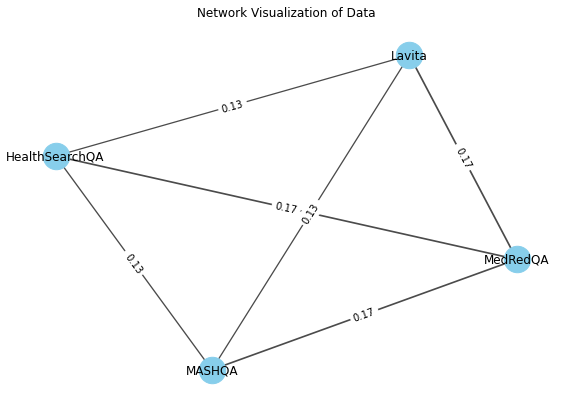

In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load data into a DataFrame
data = [
    ["Lavita", "MedRedQA", 0.17195100144771133],
    ["Lavita", "MASHQA", 0.130476996527919],
    ["Lavita", "HealthSearchQA", 0.127267373056276],
    ["MedRedQA", "MASHQA", 0.16707875942634082],
    ["MedRedQA", "HealthSearchQA", 0.1687610158527908],
    ["MASHQA", "HealthSearchQA", 0.13433413401553576]
]

df = pd.DataFrame(data, columns=["Source", "Target", "Weight"])

# Step 2: Create a graph
G = nx.Graph()

# Add edges with weights
for index, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

# Step 3: Visualize the network
plt.figure(figsize=(10, 7))

# Define positions using a spring layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

# Draw edges with varying widths based on weight
edges = G.edges(data=True)
weights = [edge[2]['weight'] * 10 for edge in edges]  # Scale weights for visibility
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

# Draw edge labels with weights
edge_labels = {(u, v): f"{w['weight']:.2f}" for u, v, w in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Network Visualization of Data")
plt.axis('off')  # Turn off axis
plt.show()
